In [1]:
import pickle
import pandas as pd
import numpy as np
# from pathlib import Path
import joblib
# import itertools as it
import py4DSTEM
# import glob
import os
from random import sample
# from time import time
# import collections
# from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from typing import Union, Optional
from scipy.signal import medfilt
# from scipy.ndimage import gaussian_filter
from matplotlib.lines import Line2D
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
import os
import sklearn
import sys 
%load_ext autoreload
%autoreload 2



In [2]:
from EDiffCrystals.diffraction_analysis import Diffraction_Analysis
from EDiffCrystals.diffraction_analysis_utils import *

In [3]:
if py4DSTEM.__version__ != '0.14.8':
    !pip install Py4DSTEM==0.14.8

In [4]:
py4DSTEM.__version__

'0.14.8'

In [5]:
sklearn.__version__

'1.2.1'

### <font size="5"> Load data and models

In [6]:
file_path = "data/EDiffCrystals_AuNPs/"
file_data = file_path + '240130-gold-nanobeam-00_master.h5'
# file_probe = file_path + 'vacuum_probe_03.dm4'
file_analysis = file_path + 'analysis_dataset00_'

bin_factor = 1

pl_filepath = 'data/EDiffCrystals_AuNPs/Au_dataset00_braggdisks_cali.h5'
# pl_filepath = 'data/EDiffCrystals_AuNPs/analysis_dataset00_TEST_braggdisks_cali.h5'

model_path_header = 'data/models/Random_Forest_Models/'

crystal_system_model_path = model_path_header+'crystal_system_model.joblib'
cubic_lattice_model_path = model_path_header+'cubic_lattice_model.joblib'
hexagonal_lattice_model_path = model_path_header+'hexagonal_lattice_model.joblib'
tetragonal_lattice_model_path = model_path_header+'tetragonal_lattice_model.joblib'
trigonal_lattice_model_path = model_path_header+'trigonal_lattice_model.joblib'
monoclinic_lattice_model_path = model_path_header+'monoclinic_lattice_model.joblib'
orthorhombic_lattice_model_path = model_path_header+'orthorhombic_lattice_model.joblib'

In [7]:
model_path_dicts = {
    'cry_sys':crystal_system_model_path,
    'cubic':cubic_lattice_model_path,
    'hexagonal':hexagonal_lattice_model_path,
    'tetragonal':tetragonal_lattice_model_path,
    'trigonal':trigonal_lattice_model_path,
    'monoclinic':monoclinic_lattice_model_path,
    'orthorhombic':orthorhombic_lattice_model_path,
}

In [8]:
diff_analysis = Diffraction_Analysis(
    pl_filepath = pl_filepath, 
    model_path_dict = model_path_dicts, 
)

In [9]:
try:
    diff_analysis.load_pls()
except RuntimeError:
    diff_analysis.load_pls()


loading point lists stored at data/EDiffCrystals_AuNPs/Au_dataset00_braggdisks_cali.h5
loading point lists stored at data/EDiffCrystals_AuNPs/Au_dataset00_braggdisks_cali.h5


Reading PointListArray: 100%|███████████████████████████████████████████| 65536/65536 [00:08<00:00, 7788.13PointList/s]


### <font size="5"> Load raw patterns

Dataset is uint32 but will be converted to uint16


Cleaning pixels: 100%|███████████████████████████████████████████████████| 65536/65536 [00:05<00:00, 11345.54 images/s]


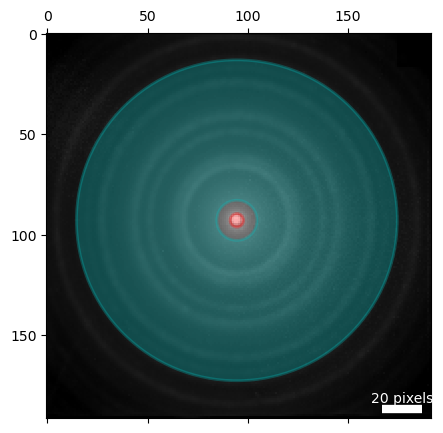

In [10]:
dataset = py4DSTEM.import_file(
    file_data,
    binfactor=bin_factor,
    scan_width=256,
)
dataset.get_dp_mean();

dataset, mask = py4DSTEM.preprocess.filter_hot_pixels(
    dataset,
    thresh=10 * bin_factor ** 2,
    return_mask=True,
    ind_compare=2,

)

dataset.get_dp_mean();
dataset.get_dp_max();

# Estimate the radius of the BF disk, and the center coordinates
probe_semiangle, probe_qx0, probe_qy0 = dataset.get_probe_size(
    thresh_lower=0.5,
    thresh_upper=0.6,
)

# virtual BF and DF

expand_BF = 2
radii_DF = (10 / bin_factor, 80 / bin_factor)

center = (probe_qx0, probe_qy0)
radius_BF = probe_semiangle + expand_BF

# Plot the detectors
py4DSTEM.visualize.show(
    dataset.tree('dp_mean'),
    annulus={
        'center': center,
        'radii': radii_DF,
        'alpha': 0.3,
        'fill': True,
        'color': 'c',
    },
    circle={
        'center': center,
        'R': radius_BF,
        'alpha': 0.3,
        'fill': True,
        'color': 'r',
    },
    vmax=1,
    scaling='log',
)

100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:03<00:00, 16780.36it/s]


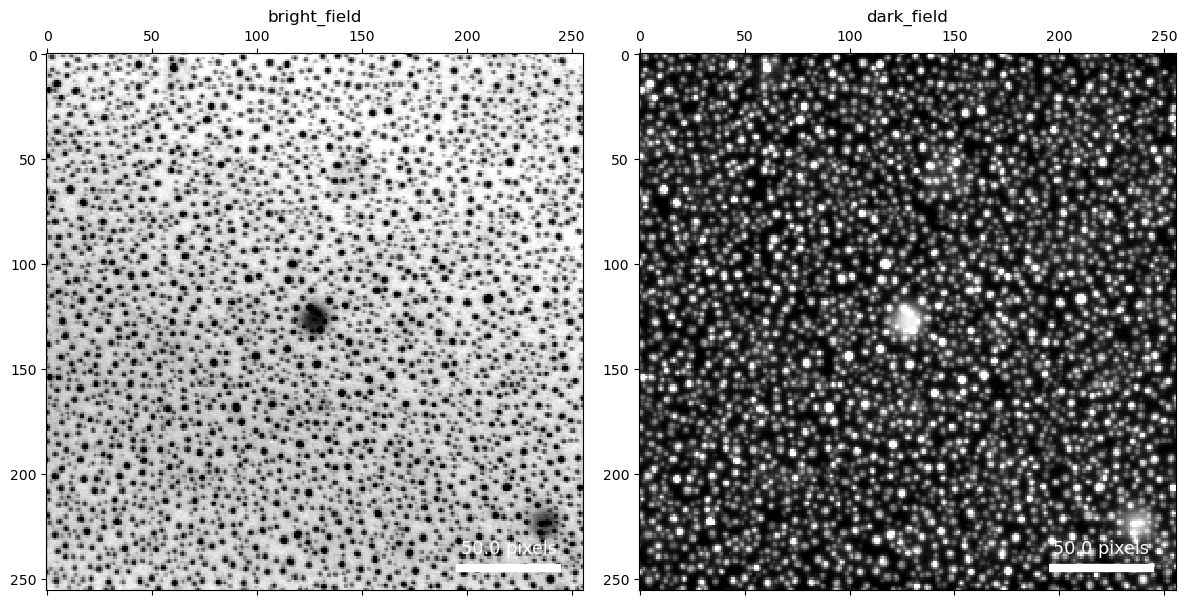

In [11]:
# Generate virtual images
dataset.get_virtual_image(
    mode = 'circle',
    geometry = (center,radius_BF),
    name = 'bright_field',
)
dataset.get_virtual_image(
    mode = 'annulus',
    geometry = (center,radii_DF),
    name = 'dark_field',
);

fig,ax = py4DSTEM.show(
    [
        dataset.tree('bright_field'),
        dataset.tree('dark_field'),
    ],
    figsize=(12,7),
    # bordercolor = 'w',
    cmap='gray',
    returnfig = True,
    title = [
        'bright_field',
        'dark_field',
    ],
    ticks = True,
)

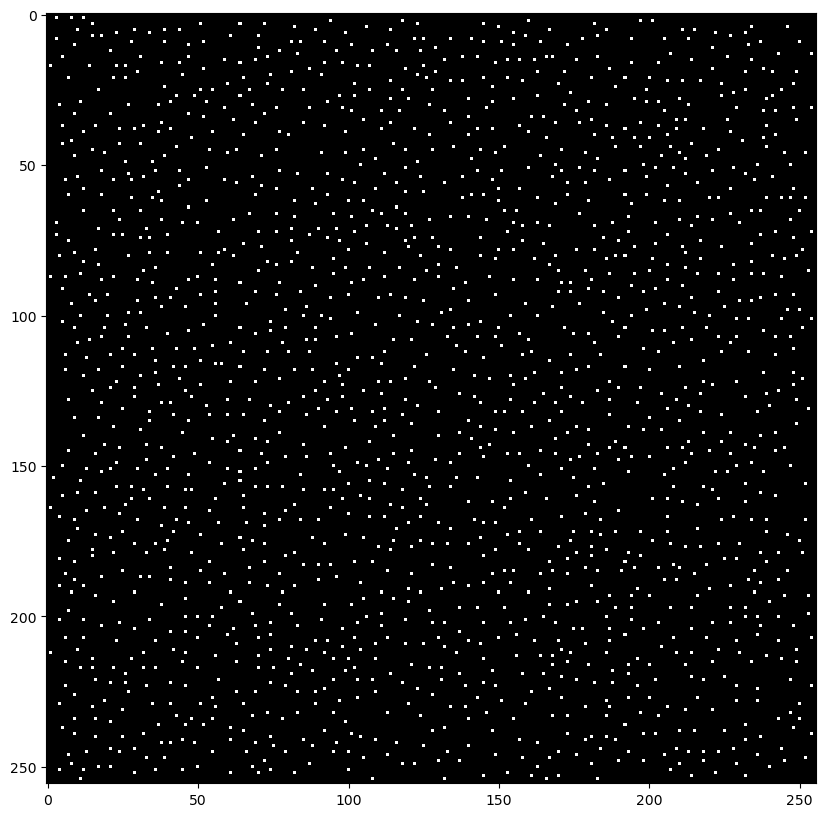

In [12]:
mask_keep = threshold_particles(
    dataset.tree('dark_field').data,
    threshold = 1e4,
    sigma = 1.0,
)
mask_keep = mask_keep.astype('int')

In [13]:
# pls_ref = py4DSTEM.read(pl_filepath)

### <font size="5"> Load Bragg Disk Array (see 

In [14]:
# count = []
# for i in range(pls_ref.shape[0]):
#     for j in range(pls_ref.shape[1]):
#         diff = len(pls_ref.cal[i,j].data) - len(pls.cal[i,j].data)
#         # if diff > 3:
#             # if len(pls_ref.cal[i,j].data) > 8:
#                 # print(i,j)
#         count.append(diff)

In [15]:
path = os.path.normpath(pl_filepath)
path = path.split(os.sep)

In [16]:
sum_scaling = 0.3
num_spots_needed = 5


sum_scaling_str = str(sum_scaling).replace('.', '_')
pl_filepath_str = path[-1].replace('.', '_')

save_path = pl_filepath_str + '_' + str(num_spots_needed) + '_spots_required_sum_scaling_' + sum_scaling_str + '_' +'including_lattice.pkl'

In [17]:
save_path

'Au_dataset00_braggdisks_cali_h5_5_spots_required_sum_scaling_0_3_including_lattice.pkl'

In [18]:
diff_analysis.prep_pls_for_prediction(sum_scaling = sum_scaling, num_spots_needed=num_spots_needed, remove_central_beam=True)

scaling patterns to sum intensity = 0.3 and filtering out patterns with fewer than 5 diffraction spots


100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [02:14<00:00,  1.90it/s]

finished scaling and filtering!


In [19]:
diff_analysis.predict_set_of_point_lists(lattice_pred_type = 'cubic', 
                                           save_df=False, 
                                         save_path=save_path)

loading crystal system model
crystal system model loaded!
building input vector
finished input vector
predicting input vector
starting


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  80 out of  80 | elapsed:    0.2s finished
100%|█████████████████████████████████████████████████████████████████████████| 44600/44600 [00:00<00:00, 49814.48it/s]


loading cubic
cubic loaded!


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [02:27<00:00,  1.85s/it]


finished predictions, adding confidence


100%|██████████████████████████████████████████████████████████████████████████| 44600/44600 [00:19<00:00, 2240.36it/s]


<font size="6"> Figure 7

[0.5281663516068068, 0.34319470699432847, 0.1286389413988647]


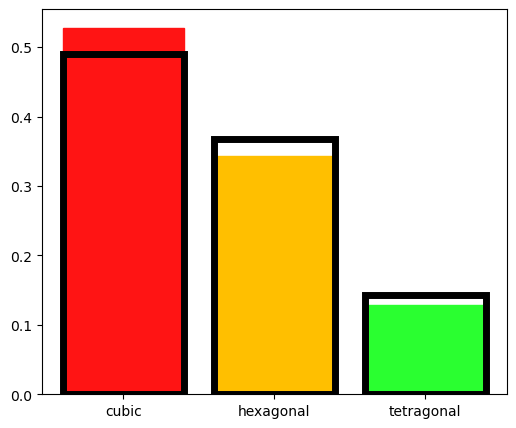

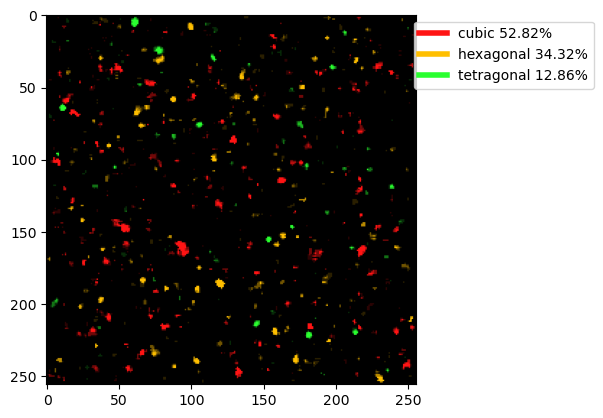

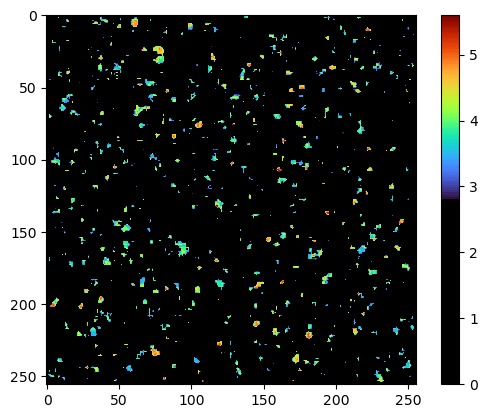

['cubic', 'hexagonal', 'tetragonal']
['cubic', 'hexagonal', 'tetragonal']


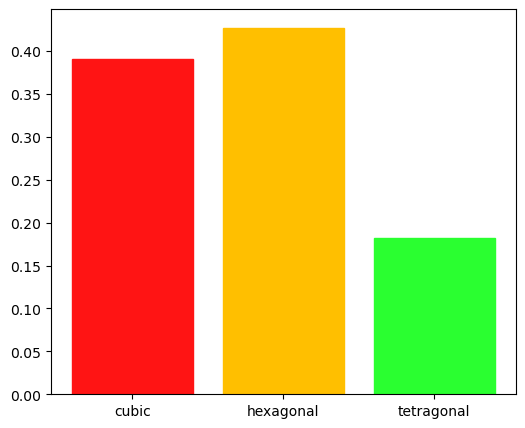

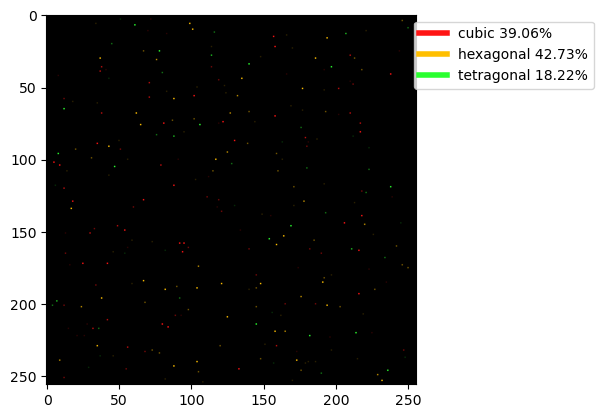

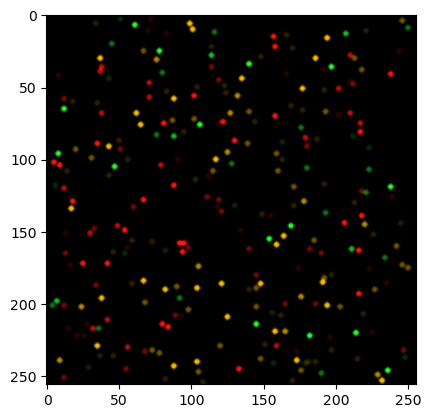

In [28]:
diff_analysis.generate_lattice_cmap(insert_length = 75, resample_length = 75) 
diff_analysis.lattice_cmap

diff_analysis.visualize_real_space_predictions(im_shape = (256, 256),
                                                plot_result = True,
                                                mask_range = (0.005, 0.05),
                                                cry_sys = [
                                                    'cubic',
                                                    'hexagonal',
                                                    'tetragonal',
                                                    # 'trigonal',
                                                    # 'orthorhombic',
                                                    # 'monoclinic',
                                                ], 
                                                mask_threshold=mask_keep,
                                              lattice_param = 'a')

median 4.03
mean 4.08


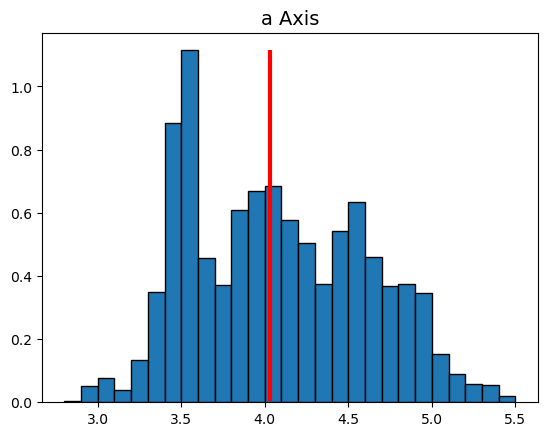

In [29]:
diff_analysis.visualize_lattice_distributions(im_shape = (256,256), lattice_params = ['a'],
                                             crystal_systems = ['one'])

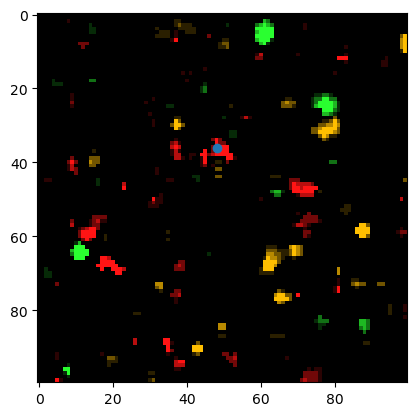

In [22]:
plt.scatter(48,36)
plt.imshow(diff_analysis.pred_image[:100:,:100])

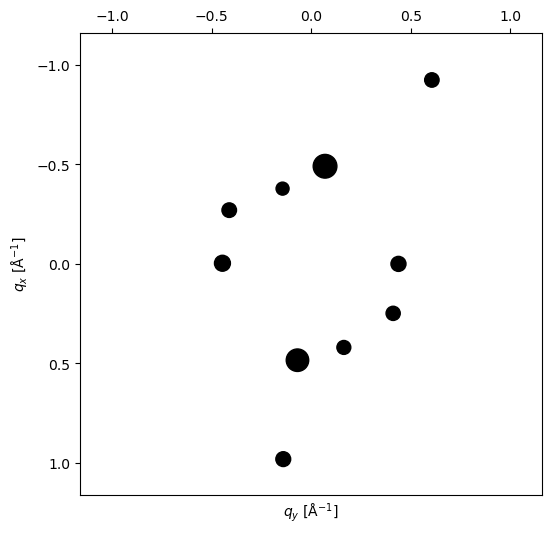

In [23]:
fig = visualize_specific_pattern(
    diff_analysis.pls, 
    index = (36,48) ,
    intensity_scaling = 1,
    )
plt.rcParams['pdf.fonttype'] = 'truetype'
# fig.savefig('cubic_pattern.pdf', bbox_inches="tight")


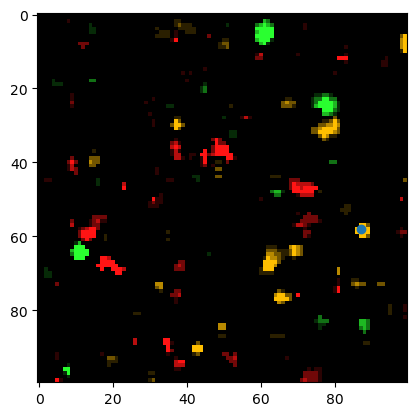

In [24]:
plt.scatter(87,58)
plt.imshow(diff_analysis.pred_image[:100:,:100])

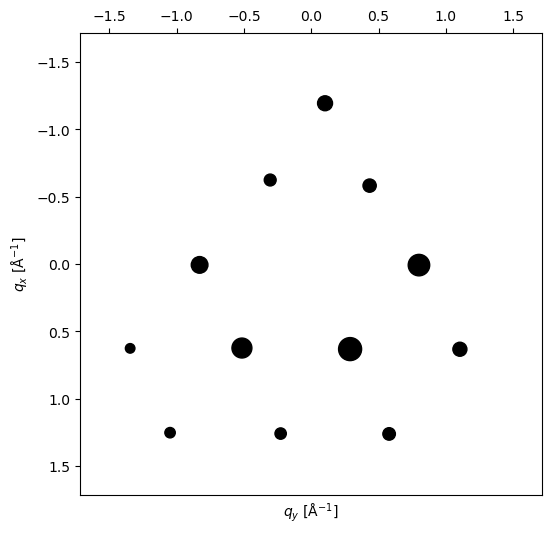

In [25]:
fig = visualize_specific_pattern(
        diff_analysis.pls, 
        index = (58,87) ,
        intensity_scaling = 1,
        )
plt.rcParams['pdf.fonttype'] = 'truetype'
# fig.savefig('hexagonal_pattern.pdf', bbox_inches="tight")

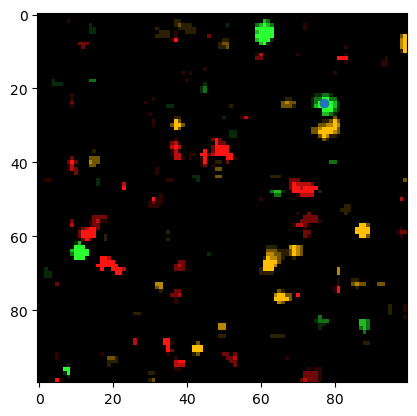

In [26]:
plt.scatter(77,24)
plt.imshow(diff_analysis.pred_image[:100:,:100])

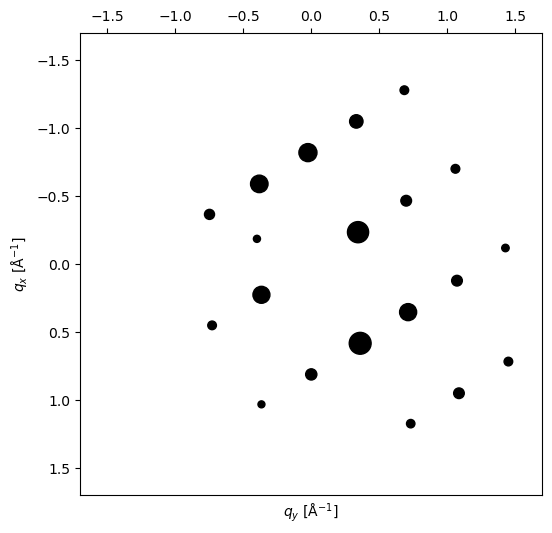

In [27]:
fig = visualize_specific_pattern(
        diff_analysis.pls, 
        index = (24,77) ,
        intensity_scaling = 1,
        )
plt.rcParams['pdf.fonttype'] = 'truetype'
# fig.savefig('tetragonal_pattern.pdf', bbox_inches="tight")

<font size="6"> Figure S4

In [33]:
from sklearn.decomposition import PCA

def dataset_visualization(input_vector):

    scaled_spectra_list = list(input_vector)

    scaled_spectra_v1 = pd.DataFrame(scaled_spectra_list).apply(pd.Series)
    scaled_spectra_v1
    print('starting pca')
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(scaled_spectra_v1)

    principalDf = pd.DataFrame(data=principalComponents)

    return [principalDf, pca]

In [34]:
input_test_fcc_gold = joblib.load('data/fcc_gold_input_vectors.joblib')

In [35]:
full_vec = []

for i in input_test_fcc_gold:
    full_vec.append([i, 'Sim Au'])

for i in diff_analysis.input_vector:
    full_vec.append([i, 'Exp Au'])

au_input_vecs = pd.DataFrame(full_vec, columns = ['input_vector', 'pattern_type'])

In [36]:
output = dataset_visualization(au_input_vecs.input_vector)

starting pca


In [37]:
output[0]['pattern_type'] = au_input_vecs['pattern_type']

In [38]:
sim_au = output[0].loc[output[0]['pattern_type'] == 'Sim Au']

In [39]:
exp_au = output[0].loc[output[0]['pattern_type'] == 'Exp Au']

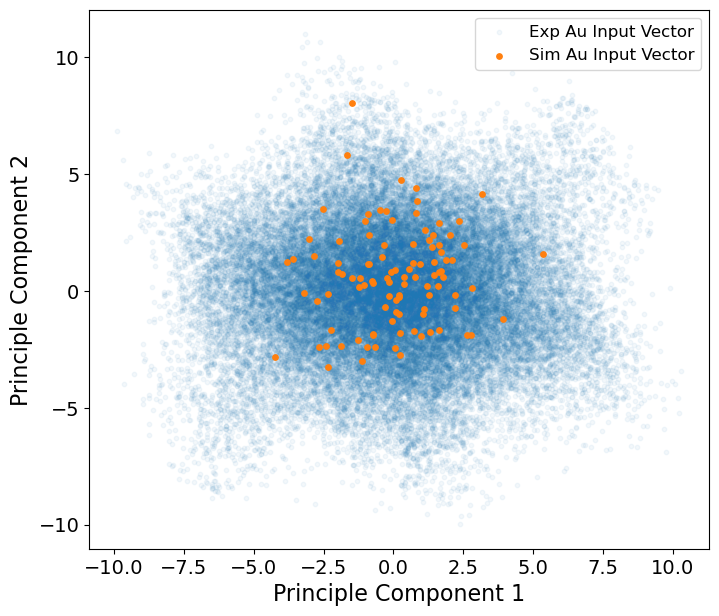

In [40]:
plt.figure(figsize = (8,7))
plt.scatter(np.asarray(exp_au[0]), np.asarray(exp_au[1]), alpha = 0.05, label = 'Exp Au Input Vector', s = 10)
plt.scatter(np.asarray(sim_au[0]), np.asarray(sim_au[1]), alpha = 1, label = 'Sim Au Input Vector', s = 15)
plt.xlabel('Principle Component 1', fontsize = 16)
plt.ylabel('Principle Component 2', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 12)
plt.rcParams['pdf.fonttype'] = 'truetype'
# plt.savefig('PCA_Au_Exp.pdf', bbox_inches = 'tight')

<font size="6"> Figure S10

In [ ]:
diff_analysis.predict_set_of_point_lists(lattice_pred_type = 'all', 
                                           save_df=False, 
                                         save_path=save_path)

5


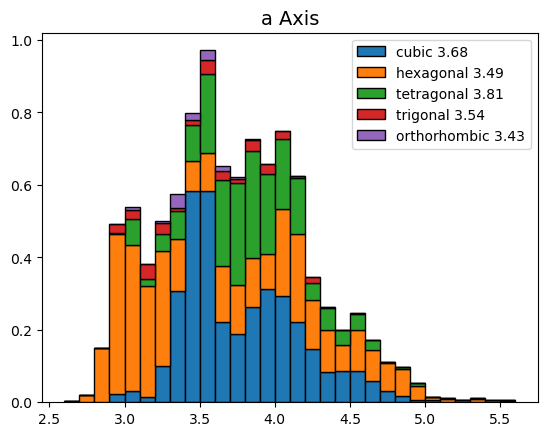

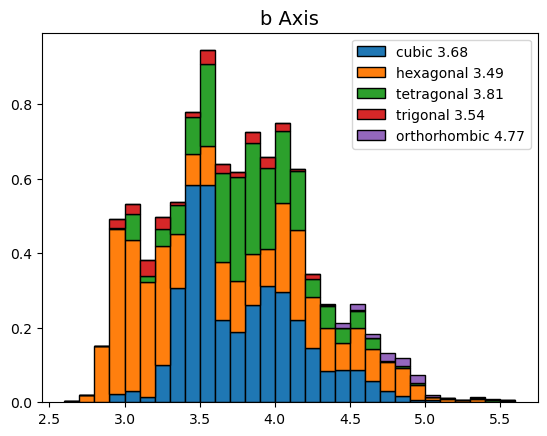

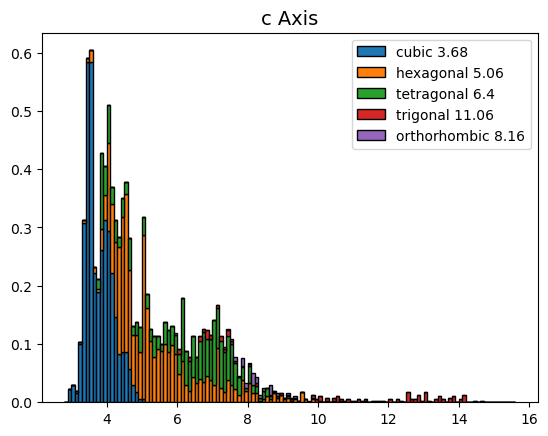

In [41]:
diff_analysis.visualize_lattice_distributions(im_shape = (256,256), lattice_params = ['a', 'b', 'c'],
                                             crystal_systems = ('cubic', 'hexagonal', 'tetragonal', 'trigonal', 'orthorhombic'))

4


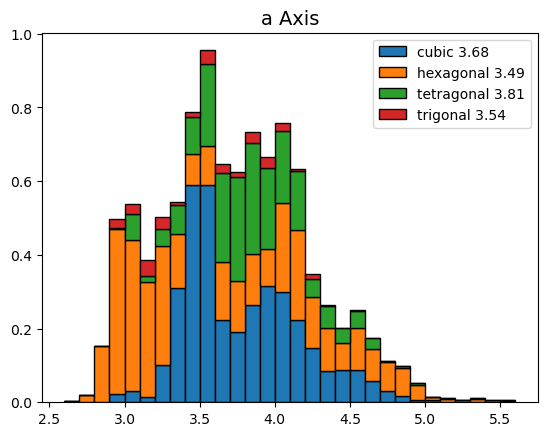

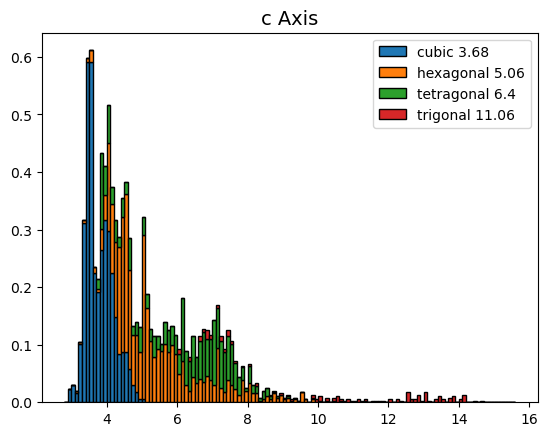

In [42]:
diff_analysis.visualize_lattice_distributions(im_shape = (256,256), lattice_params = ['a', 'c'],
                                             crystal_systems = ('cubic', 'hexagonal', 'tetragonal', 'trigonal'))